In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import PIL
import os
import numpy as np
import pandas as pd
import torch
import random
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/age_detection/data/'
data_path_train = '/content/drive/MyDrive/Colab Notebooks/age_detection/data/train/'
data_path_test = '/content/drive/MyDrive/Colab Notebooks/age_detection/data/test/'

In [ ]:
counts = {}
def count_files(start_path):
  counts[start_path] = 0
  for name in os.listdir(start_path):
    if os.path.isdir(f'{start_path}{name}/'):
      count_files(f'{start_path}{name}/')
    else:
      counts[start_path] += 1

count_files(data_path)

In [ ]:
counts

{'/content/drive/MyDrive/Colab Notebooks/age_detection/data/': 1,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/test/': 0,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/test/21-30/': 5,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/test/41-50/': 5,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/test/51-60/': 5,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/test/18-20/': 5,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/test/31-40/': 5,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/train/': 0,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/train/41-50/': 25,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/train/18-20/': 25,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/train/21-30/': 25,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/train/31-40/': 25,
 '/content/drive/MyDrive/Colab Notebooks/age_detection/data/train/51-60/': 25}

* Link PDF: https://drive.google.com/drive/u/0/folders/1MZ9lhzGKABXLMTJzeIM2b-zi7YJnn6WR
* Link Chess: https://github.com/LeventSoykan/Chess_Piece_Image_Classification_With_CNN/blob/main/image_classification.ipynb
* Dataset: https://susanqq.github.io/UTKFace/


In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_train = datasets.ImageFolder(
    data_path_train,
    transform = train_transforms
)

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_test = datasets.ImageFolder(
    data_path_test,
    transform = test_transforms
)



In [ ]:
dataloader_train = DataLoader(
    dataset_train,
    shuffle = True,
    batch_size = 1
)

image, label = next(iter(dataloader_train))
print(image.shape)

torch.Size([1, 3, 128, 128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
image = image.squeeze().permute(1, 2, 0)
print(image.shape)

torch.Size([128, 128, 3])


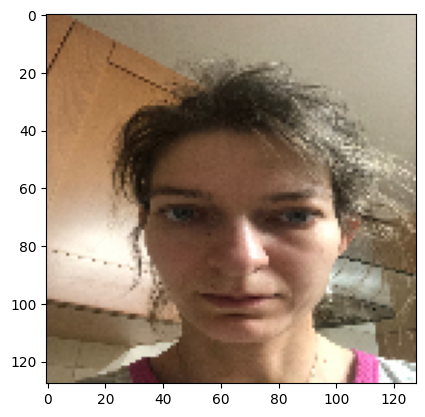

In [ ]:

plt.imshow(image)
plt.show()

In [ ]:
class AgeDetectNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten()
    )
    self.classifier = nn.Linear(16*32*32, num_classes)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.classifier(x)
    return x

In [ ]:
net = Net(num_classes=5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print(Net)

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# number of epochs to train the model
n_epochs = 5

device = 'cpu'
model.to(device)

t0 = time.time()


valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    i=0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate batch accuracy
        probs = nn.functional.softmax(output, dim=1)
        preds = torch.argmax(probs, axis=1)
        accuracy = (abs(preds-labels)==0).type(torch.float).mean()
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss & accuracy
        train_loss += loss.item()*images.size(0)
        train_accuracy += accuracy*images.size(0)

        #inform user about elapsed time in every 320 batches (320x32=10240 images)
        i += 1
        if i % 320 == 0:
            t1 = time.time()
            print(f'{i*images.shape[0]} items processed in {format_time(t1-t0)}')


    ######################
    # Validate the model #
    ######################
    model.eval()
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate batch accuracy
        probs = nn.functional.softmax(output, dim=1)
        preds = torch.argmax(probs, axis=1)
        accuracy = (abs(preds-labels)==0).type(torch.float).mean()
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss & accuracy
        valid_loss += loss.item()*images.size(0)
        valid_accuracy += accuracy*images.size(0)

    # calculate average losses & accuracies
    train_loss = train_loss/len(train_dataloader.sampler)
    valid_loss = valid_loss/len(val_dataloader.sampler)
    train_accuracy = train_accuracy/len(train_dataloader.sampler)
    valid_accuracy = valid_accuracy/len(val_dataloader.sampler)

    # print training/testation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_accuracy, valid_accuracy))

    # save model if testation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_chess.pt')
        valid_loss_min = valid_loss

In [ ]:
net = Net(num_classes=5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(10):
  for images,labels in dataloader_train:
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()